In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\gpie


In [2]:
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.gaussian_measurement import GaussianMeasurement
from core.linalg_utils import random_unitary_matrix
import numpy as np

In [3]:
# === パラメータ設定 ===
n = 64
shape = (n,)
var = 1e-4
rng = np.random.default_rng(123)

U1 = random_unitary_matrix(n, rng=rng)
U2 = random_unitary_matrix(n, rng=rng)

In [4]:
# === グラフ定義 ===
class SplitGraph(Graph):
    def __init__(self):
        super().__init__()
        X = ~GaussianPrior(var=1.0, shape=shape, label = "x")
        Y1 = UnitaryPropagator(U1) @ X
        Y2 = UnitaryPropagator(U2) @ X
        with self.observe():
            Z1 = GaussianMeasurement(var=var) @ Y1
            Z2 = GaussianMeasurement(var=var) @ Y2
        self.compile()

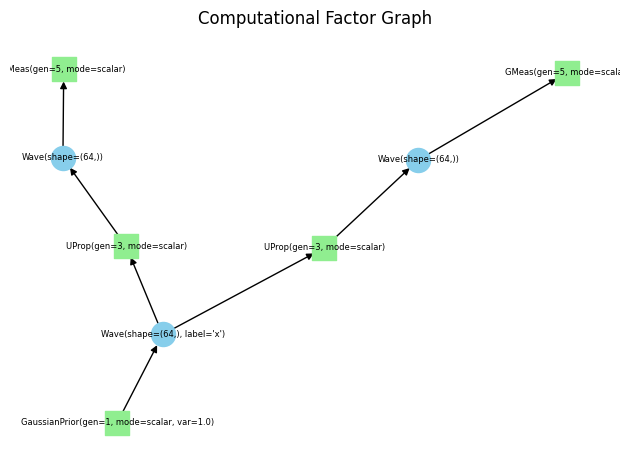

In [5]:
g = SplitGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [6]:
g.visualize_bokeh()

Loading BokehJS ...

In [7]:
g.set_init_rng(np.random.default_rng(1))
g.generate_sample(rng=np.random.default_rng(9), update_observed = True)

X = g.get_wave("x")
true_x = X.get_sample()

In [8]:
def monitor(graph, t):
    if t % 10 == 0:
        est = X.compute_belief().data
        err = np.mean(np.abs(est - true_x)**2)
        print(f"[t={t}] MSE = {err:.3e}")

g.run(n_iter=50, callback=monitor)

BP Iteration: 100%|██████████| 50/50 [00:00<00:00, 2510.72it/s]

[t=0] MSE = 4.449e-05
[t=10] MSE = 4.448e-05
[t=20] MSE = 4.448e-05
[t=30] MSE = 4.448e-05
[t=40] MSE = 4.448e-05


## Coded Diffraction Pattern

In [9]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import random_phase_mask
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(seed=42)

class CDPGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = ~GaussianPrior(var=1.0, shape=shape, label = "object")

        # Measurement を self に明示的に保持
        self.Z_list = []
        for i in range(4):
            phase = random_phase_mask(shape, rng=rng)
            Y = PhaseMaskPropagator(phase) @ self.X
            F = FFT2DPropagator(shape=shape) @ Y
            Z = AmplitudeMeasurement(var=var, damping=0.3) @ F
            setattr(self, f"Z{i+1}", Z)  # self.Z1, self.Z2, ... に登録
            self.Z_list.append(Z)

        self.compile()

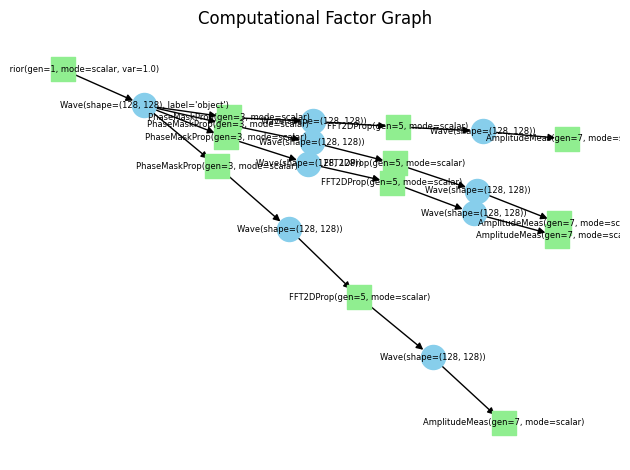

In [10]:
g = CDPGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [11]:
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
true_x = g.X.get_sample()

In [12]:
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor,verbose = False)

[t=0] PMSE = 1.12109e+00
[t=20] PMSE = 1.42257e+00
[t=40] PMSE = 3.21883e-01
[t=60] PMSE = 3.83846e-04
[t=80] PMSE = 1.51765e-04
[t=100] PMSE = 1.50995e-04
[t=120] PMSE = 1.50997e-04
[t=140] PMSE = 1.50997e-04
[t=160] PMSE = 1.50997e-04
[t=180] PMSE = 1.50997e-04


In [13]:
g.visualize_bokeh()

Loading BokehJS ...